# Часть 1 Бустинг (5 баллов)

В этой части будем предсказывать зарплату data scientist-ов в зависимости  от ряда факторов с помощью градиентного бустинга.

В датасете есть следующие признаки:



* work_year: The number of years of work experience in the field of data science.

* experience_level: The level of experience, such as Junior, Senior, or Lead.

* employment_type: The type of employment, such as Full-time or Contract.

* job_title: The specific job title or role, such as Data Analyst or Data Scientist.

* salary: The salary amount for the given job.

* salary_currency: The currency in which the salary is denoted.

* salary_in_usd: The equivalent salary amount converted to US dollars (USD) for comparison purposes.

* employee_residence: The country or region where the employee resides.

* remote_ratio: The percentage of remote work offered in the job.

* company_location: The location of the company or organization.

* company_size: The company's size is categorized as Small, Medium, or Large.

In [ ]:
import pandas as pd

df = pd.read_csv("ds_salaries.csv")
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


## Задание 1 (0.5 балла) Подготовка



*   Разделите выборку на train, val, test (80%, 10%, 10%)
*   Выдерите salary_in_usd в качестве таргета
*   Найдите и удалите признак, из-за которого возможен лик в данных


In [ ]:
from sklearn.model_selection import train_test_split

y = df['salary_in_usd']
X = df.drop('salary_in_usd', axis = 1)

Лик в данных возможен из-за признака salary, так как этот признак после конвертации в доллары США представляет из себя таргет, то есть отличается всего одним линейным преобразованием.

In [ ]:
X = X.drop('salary', axis = 1)

In [ ]:
X_train, X_val_and_test, y_train, y_val_and_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

X_val, X_test, y_val, y_test = train_test_split(X_val_and_test, y_val_and_test, test_size = 0.5, random_state = 0)

In [ ]:
print('Размер train:', len(X_train))
print('Размер val:', len(X_val))
print('Размер test:', len(X_test))

Размер train: 3004
Размер val: 375
Размер test: 376


## Задание 2 (0.5 балла) Линейная модель


*   Закодируйте категориальные  признаки с помощью OneHotEncoder
*   Обучите модель линейной регрессии
*   Оцените  качество через MAPE и RMSE


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
import numpy as np

categorical_features = ['experience_level', 'employment_type', 'job_title', 'salary_currency', 'employee_residence', 'company_location', 'company_size']

encoder = OneHotEncoder(sparse_output = False, handle_unknown = 'ignore')

# кодируем train
X_train_encoded = encoder.fit_transform(X_train[categorical_features])
X_train = np.concatenate((X_train.drop(categorical_features, axis=1), X_train_encoded), axis=1)

# кодируем val
X_val_encoded = encoder.transform(X_val[categorical_features])
X_val = np.concatenate((X_val.drop(categorical_features, axis=1), X_val_encoded), axis=1)

# кодируем test
X_test_encoded = encoder.transform(X_test[categorical_features])
X_test = np.concatenate((X_test.drop(categorical_features, axis=1), X_test_encoded), axis=1)

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print('MAPE: ', mean_absolute_percentage_error(y_test, y_pred))
print('RMSE: ', mean_squared_error(y_test, y_pred, squared=False))

MAPE:  57727563.09250397
RMSE:  9627718793553.238


## Задание 3 (0.5 балла) XGboost

Начнем с библиотеки xgboost.

Обучите модель `XGBRegressor` на тех же данных, что линейную модель, подобрав оптимальные гиперпараметры (`max_depth, learning_rate, n_estimators, gamma`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [ ]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV
import time

params = {
    'max_depth' : [3, 4, 5] ,
    'learning_rate' : [0.01, 0.025, 0.05] ,
    'n_estimators' : [300, 500, 700] ,
    'gamma' : [0, 0.025, 0.05] ,
    'min_child_weight': [3, 4] ,
    'subsample' : [0.9, 1] ,
    'reg_alpha' : [0, 0.05]
}

model_xgb = XGBRegressor(random_state = 100)

gsearch = GridSearchCV(
    estimator = model_xgb, param_grid = params, scoring = 'neg_mean_squared_error', n_jobs = -1, cv=5
)

# подбираем оптимальные гиперпараметры
gsearch.fit(X_val, y_val)

gsearch.best_params_, gsearch.best_score_

({'gamma': 0,
  'learning_rate': 0.01,
  'max_depth': 4,
  'min_child_weight': 4,
  'n_estimators': 300,
  'reg_alpha': 0.05,
  'subsample': 1},
 -2569271374.076073)

In [ ]:
best_model_xgb = XGBRegressor(**gsearch.best_params_, random_state = 100)

fit_start_time = time.time()
best_model_xgb.fit(X_train, y_train)
fit_time = time.time() - fit_start_time

prediction_start_time = time.time()
y_pred = best_model_xgb.predict(X_test)
prediction_time = time.time() - prediction_start_time

print('MAPE: ', mean_absolute_percentage_error(y_test, y_pred))
print('RMSE: ', mean_squared_error(y_test, y_pred, squared=False))
print('fit speed:', fit_time)
print('pred speed:', prediction_time)

MAPE:  0.37809920386617274
RMSE:  52705.978692584256
fit speed: 2.9654300212860107
pred speed: 0.03515481948852539


## Задание 4 (1 балл) CatBoost

Теперь библиотека CatBoost.

Обучите модель `CatBoostRegressor`, подобрав оптимальные гиперпараметры (`depth, learning_rate, iterations`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [ ]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 4.9 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostRegressor

params = {
    'depth': [5, 6, 7] ,
    'learning_rate' : [0.01, 0.025, 0.05] ,
    'iterations' : [200, 300, 400] ,
    'l2_leaf_reg' : [1, 3, 5] ,
    'subsample' : [0.9, 1]
}

cat = CatBoostRegressor(random_state = 100)

gsearch = GridSearchCV(
    estimator = cat, param_grid = params, scoring = 'neg_mean_squared_error', n_jobs = -1, cv=5
)

# подбираем оптимальные гиперпараметры
gsearch.fit(X_val, y_val, verbose = False)

gsearch.best_params_, gsearch.best_score_

({'depth': 5,
  'iterations': 300,
  'l2_leaf_reg': 1,
  'learning_rate': 0.025,
  'subsample': 1},
 -2624229059.597026)

In [ ]:
best_model_cat = CatBoostRegressor(**gsearch.best_params_, random_state = 100)

fit_start_time = time.time()
best_model_cat.fit(X_train, y_train, eval_set = (X_val, y_val), verbose = False)
fit_time = time.time() - fit_start_time

prediction_start_time = time.time()
y_pred = best_model_cat.predict(X_test)
prediction_time = time.time() - prediction_start_time

print('MAPE: ', mean_absolute_percentage_error(y_test, y_pred))
print('RMSE: ', mean_squared_error(y_test, y_pred, squared=False))
print('fit speed:', fit_time)
print('pred speed:', prediction_time)

MAPE:  0.3620735464890318
RMSE:  52256.37674357073
fit speed: 0.6940340995788574
pred speed: 0.08151912689208984


Для применения catboost моделей не обязательно сначала кодировать категориальные признаки, модель может кодировать их сама. Обучите catboost с подбором оптимальных гиперпараметров снова, используя pool для передачи данных в модель с указанием какие признаки категориальные, а какие нет с помощью параметра cat_features. Оцените качество и время. Стало ли лучше?

In [ ]:
from sklearn.model_selection import train_test_split

X_train_cat, X_val_and_test_cat = train_test_split(X, test_size = 0.2, random_state = 0)

X_val_cat, X_test_cat = train_test_split(X_val_and_test, test_size = 0.5, random_state = 0)

In [ ]:
from catboost import Pool

categorical_features_indices = [X.columns.get_loc(column) for column in categorical_features]

# создаем Pool для train, val, test
train_pool = Pool(data = X_train_cat, label = y_train, cat_features = categorical_features_indices)
val_pool = Pool(data = X_val_cat, label = y_val, cat_features = categorical_features_indices)
test_pool = Pool(data = X_test_cat, label = y_test, cat_features = categorical_features_indices)

In [ ]:
cat = CatBoostRegressor(random_state = 100)

gsearch = GridSearchCV(
    estimator = cat, param_grid = params, scoring = 'neg_mean_squared_error', n_jobs = -1, cv=5
)

# подбираем оптимальные гиперпараметры
gsearch.fit(X_val_cat, y_val, verbose = False, cat_features = categorical_features_indices)

gsearch.best_params_, gsearch.best_score_

({'depth': 5,
  'iterations': 300,
  'l2_leaf_reg': 5,
  'learning_rate': 0.05,
  'subsample': 0.9},
 -2611961892.192321)

In [ ]:
best_model_cat = CatBoostRegressor(**gsearch.best_params_, random_state = 100)

fit_start_time = time.time()
best_model_cat.fit(train_pool, eval_set = val_pool, verbose = False)
fit_time = time.time() - fit_start_time

prediction_start_time = time.time()
y_pred = best_model_cat.predict(test_pool)
prediction_time = time.time() - prediction_start_time

print('MAPE: ', mean_absolute_percentage_error(y_test, y_pred))
print('RMSE: ', mean_squared_error(y_test, y_pred, squared=False))
print('fit speed:', fit_time)
print('pred speed:', prediction_time)

MAPE:  0.3401744948615245
RMSE:  52028.95094137424
fit speed: 1.3021240234375
pred speed: 0.001344442367553711


**Ответ:** По результатам видно, что MAPE и RMSE значительно снизилось, также изменились значения гиперпараметров, что говорит об существенном влиянии способа кодирования на модель, так что можно утверждать, что, в данном случае, когда модель сама кодирует категориальные признаки, качество становится лучше.

Время обучения выросло в два раза, а время предсказания снизилось практически до нуля.

## Задание 5 (0.5 балла) LightGBM

И наконец библиотека LightGBM - используйте `LGBMRegressor`, снова подберите гиперпараметры, оцените качество и скорость.


In [ ]:
from lightgbm import LGBMRegressor


params = {
    'max_depth' : [2, 3, 4] ,
    'learning_rate' : [0.01, 0.025, 0.05] ,
    'n_estimators' : [300, 500, 700] ,
    'num_leaves' : [25, 30, 35] ,
    'min_child_weight': [3, 4] ,
    'subsample' : [0.9, 1],
    'reg_alpha' : [0, 0.05, 0.1]
}

model_lgb = LGBMRegressor()

gsearch = GridSearchCV(
    estimator = model_lgb, param_grid = params, scoring = 'neg_mean_squared_error', n_jobs = -1, cv=5
)

# подбираем оптимальные гиперпараметры
gsearch.fit(X_val, y_val)

gsearch.best_params_, gsearch.best_score_

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34
[LightGBM] [Info] Number of data points in the train set: 375, number of used features: 15
[LightGBM] [Info] Start training from score 141485.954667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

({'learning_rate': 0.05,
  'max_depth': 3,
  'min_child_weight': 3,
  'n_estimators': 500,
  'num_leaves': 25,
  'reg_alpha': 0.1,
  'subsample': 0.9},
 -2657527691.9153376)

In [ ]:
best_model_lgb = LGBMRegressor(**gsearch.best_params_, random_state = 100)

fit_start_time = time.time()
best_model_lgb.fit(X_train, y_train)
fit_time = time.time() - fit_start_time

prediction_start_time = time.time()
y_pred = best_model_lgb.predict(X_test)
prediction_time = time.time() - prediction_start_time

print('MAPE: ', mean_absolute_percentage_error(y_test, y_pred))
print('RMSE: ', mean_squared_error(y_test, y_pred, squared=False))
print('fit speed:', fit_time)
print('pred speed:', prediction_time)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 3004, number of used features: 41
[LightGBM] [Info] Start training from score 136404.995340
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

## Задание 6 (2 балла) Сравнение и выводы

Сравните модели бустинга и сделайте про них выводы, какая из моделей показала лучший/худший результат по качеству, скорости обучения и скорости предсказания? Как отличаются гиперпараметры для разных моделей?

**Ответ:** Лучший результат по качеству MAPE показала модель LightGBM, а по качеству RMSE - CatBoost. Худшей же моделью по качеству оказался XGboost.

По скорости обучения наилучший результат показал LightGBM (да и было заметно, что параметры для этой модели подбираются намного быстрее), а по скорости предсказания - CatBoost. XGboost снова показал худшие результаты.

По гиперпараметрам видно, что XGboost посчитал оптимальным низкий learning_rate, то есть у каждой новой базовой модели низкий вклад в общую модель, а CatBoost и LightGBM посчитали оптимальным высокий learning_rate. n_estimators (максимальное количество построенных деревьев) одинаково в XGboost и CatBoost, а больше всего в LightGBM, но это компенсируется глубиной деревьев - у LightGBM она меньше всех. Также LightGBM и CatBoost выдали оптимальное значение гиперпараметра subsample (доля объектов, которая будет использоваться для обучения каждого отдельного дерева) не равное 1, таким образом деревья будут более разнообразными, чем у XGboost, что снижает переобученность.

# Часть 2 Кластеризация (5 баллов)

Будем работать с данными о том, каких исполнителей слушают пользователи музыкального сервиса.

Каждая строка таблицы - информация об одном пользователе. Каждый столбец - это исполнитель (The Beatles, Radiohead, etc.)

Для каждой пары (пользователь, исполнитель) в таблице стоит число - доля прослушивания этого исполнителя этим пользователем.


In [1]:
import pandas as pd
ratings = pd.read_excel("https://github.com/evgpat/edu_stepik_rec_sys/blob/main/datasets/sample_matrix.xlsx?raw=true", engine='openpyxl')
ratings.head()

,user,the beatles,radiohead,deathcab for cutie,coldplay,modest mouse,sufjan stevens,dylan. bob,red hot clili peppers,pink fluid,...,municipal waste,townes van zandt,curtis mayfield,jewel,lamb,michal w. smith,群星,agalloch,meshuggah,yellowcard
0,0,NaN,0.020417,NaN,NaN,NaN,NaN,NaN,0.030496,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,0.184962,0.024561,NaN,NaN,0.136341,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,0.028635,NaN,NaN,NaN,0.024559,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0.043529,0.086281,0.034590,0.016712,0.015935,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Будем строить кластеризацию исполнителей: если двух исполнителей слушало много людей примерно одинаковую долю своего времени (то есть векторы близки в пространстве), то, возможно исполнители похожи. Эта информация может быть полезна при построении рекомендательных систем.

## Задание 1 (0.5 балла) Подготовка

Транспонируем матрицу ratings, чтобы по строкам стояли исполнители.

In [2]:
import numpy as np
ratings = np.transpose(ratings)
ratings.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
user,0.000000,1.000000,2.000000,3.0,4.000000,5.000000,6.0,7.0,8.000000,9.000000,...,4990.000000,4991.0,4992.000000,4993.000000,4994.000000,4995.000000,4996.0,4997.000000,4998.0,4999.000000
the beatles,NaN,NaN,NaN,NaN,0.043529,NaN,NaN,NaN,0.093398,0.017621,...,NaN,NaN,0.121169,0.038168,0.007939,0.017884,NaN,0.076923,NaN,NaN
radiohead,0.020417,0.184962,NaN,NaN,0.086281,0.006322,NaN,NaN,NaN,0.019156,...,0.017735,NaN,NaN,NaN,0.011187,NaN,NaN,NaN,NaN,NaN
deathcab for cutie,NaN,0.024561,0.028635,NaN,0.034590,NaN,NaN,NaN,NaN,0.013349,...,0.121344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027893
coldplay,NaN,NaN,NaN,NaN,0.016712,NaN,NaN,NaN,NaN,NaN,...,0.217175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Выкиньте строку под названием `user`.

In [3]:
ratings = ratings.drop('user', axis = 0)

В таблице много пропусков, так как пользователи слушают не всех-всех исполнителей, чья музыка представлена в сервисе, а некоторое подмножество (обычно около 30 исполнителей)


Доля исполнителя в музыке, прослушанной  пользователем, равна 0, если пользователь никогда не слушал музыку данного музыканта, поэтому заполните пропуски нулями.



In [4]:
ratings = ratings.fillna(0)
ratings.sample()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
mxpx,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Задание 2 (0.5 балла) Первая кластеризация

Примените KMeans с 5ю кластерами, сохраните полученные лейблы

In [5]:
from sklearn.cluster import KMeans
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

k_means = KMeans(n_clusters = 5, random_state = 0)
k_means = k_means.fit(ratings)
clusters = k_means.predict(ratings)

Выведите размеры кластеров. Полезной ли получилась кластеризация? Почему KMeans может выдать такой результат?

In [6]:
sizes = np.bincount(clusters)
np.transpose(pd.DataFrame({'size': sizes}))

,0,1,2,3,4
size,996,1,1,1,1


**Ответ:** В данном случае кластеризацию нельзя назвать полезной, так как практически все объекты попали в нулевой кластер, а в остальные кластеры попало по одному объекту, таким образом мы не смогли успешно разделить наше пространство объектов на группы, на основе близости значений их признаков.

KMeans может выдать такой результат, если в данных присутствуют выбросы, которые могут сильно повлиять на расположение центроидов. KMeans чувствителен к выбросам, потому что он использует Евклидово расстояние для определения близости между точками и центроидами. Выбросы могут иметь большое Евклидово расстояние от остальных точек, что приводит к тому, что они оказываются в своих собственных кластерах. Для избежания этого данные стоит нормализовать, тогда аномальные значения признаков у выбросов перейдут в меньший диапазон, Евклидово расстояние значительно снизится, и эти объекты не окажутся в своих собственных кластерах.

## Задание 3 (0.5 балла) Объяснение результатов

При кластеризации получилось $\geq 1$ кластера размера 1. Выведите исполнителей, которые составляют такие кластеры. Среди них должна быть группа The Beatles.

In [7]:
artists_and_clusters = pd.DataFrame({'cluster' : clusters}, index = ratings.index)
artists_and_clusters[artists_and_clusters['cluster'] != 0]

,cluster
the beatles,2
daft punk,1
morricone,4
보아,3


Изучите данные, почему именно The Beatles выделяется?

Подсказка: посмотрите на долю пользователей, которые слушают каждого исполнителя, среднюю долю прослушивания.

In [8]:
pd.DataFrame({'share of users' : np.count_nonzero(ratings, axis = 1)/len(ratings.columns)}, index = ratings.index)

,share of users
the beatles,0.3342
radiohead,0.2778
deathcab for cutie,0.1862
coldplay,0.1682
modest mouse,0.1628
...,...
michal w. smith,0.0094
群星,0.0094
agalloch,0.0094
meshuggah,0.0094


In [9]:
pd.DataFrame({'share of listening' : np.mean(ratings, axis = 1)}, index = ratings.index)

,share of listening
the beatles,0.018369
radiohead,0.011851
deathcab for cutie,0.006543
coldplay,0.006030
modest mouse,0.005876
...,...
michal w. smith,0.000895
群星,0.000519
agalloch,0.000997
meshuggah,0.000431


**Ответ:** группа The Beatles выделяется, так как ее слушают больше всего пользователей, и средняя доля прослушивания у нее наибольшая, таким образом этот объект является уникальным (можно сказать самая популярная группа), а остальные группы не смогли близко приблизиться к таким же результатам, поэтому The Beatles был отнесен к отдельному кластеру.

## Задание 4 (0.5 балла) Улучшение кластеризации

Попытаемся избавиться от этой проблемы: нормализуйте данные при помощи `normalize`.

In [10]:
from sklearn.preprocessing import normalize

ratings_normalized = pd.DataFrame(normalize(ratings), columns = ratings.columns, index = ratings.index)
ratings_normalized.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
the beatles,0.000000,0.000000,0.000000,0.0,0.012054,0.000000,0.0,0.0,0.025864,0.004880,...,0.000000,0.0,0.033554,0.010569,0.002199,0.004952,0.0,0.021302,0.0,0.000000
radiohead,0.009348,0.084688,0.000000,0.0,0.039505,0.002894,0.0,0.0,0.000000,0.008771,...,0.008120,0.0,0.000000,0.000000,0.005122,0.000000,0.0,0.000000,0.0,0.000000
deathcab for cutie,0.000000,0.017278,0.020144,0.0,0.024333,0.000000,0.0,0.0,0.000000,0.009391,...,0.085361,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.019622
coldplay,0.000000,0.000000,0.000000,0.0,0.011129,0.000000,0.0,0.0,0.000000,0.000000,...,0.144628,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
modest mouse,0.000000,0.000000,0.000000,0.0,0.010260,0.000000,0.0,0.0,0.000000,0.019597,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000


Примените KMeans с 5ю кластерами на преобразованной матрице, посмотрите на их размеры. Стало ли лучше? Может ли кластеризация быть полезной теперь?

In [11]:
k_means = KMeans(n_clusters = 5, random_state = 0)
k_means = k_means.fit(ratings_normalized)
clusters = k_means.predict(ratings_normalized)

In [12]:
sizes = np.bincount(clusters)
np.transpose(pd.DataFrame({'size': sizes}))

,0,1,2,3,4
size,210,132,227,89,342


**Ответ** По результатам видно, что теперь размеры кластеров отличаются не так сильно, как раньше и минимальный кластер теперь содержит 89 объектов, а максимальный - 342 (раньше было 1 и 996), так что размах стал намного меньше, поэтому можно утверждать, что после нормализации стало лучше.

Теперь кластеризация может быть полезной, так как после нормализации KMeans стал лучше определять, насколько объекты близки между собой, следовательно, с бОльшей вероятностью в кластерах находятся похожие друг на друга объекты, чего мы и добиваемся.

## Задание 5 (1 балл) Центроиды

Выведите для каждого кластера названия топ-10 исполнителей, ближайших к центроиду по косинусной мере. Проинтерпретируйте результат. Что можно сказать о смысле кластеров?

In [13]:
from scipy.spatial.distance import cosine

centroids = k_means.cluster_centers_
top_10 = pd.DataFrame()

# для каждого центроида сортируем объекты по возрастанию расстояния по косинусной мере
for i in range(len(centroids)):
  distances = [cosine(centroids[i], ratings_normalized.iloc[j].values) for j in range(len(ratings_normalized))]
  artists_and_distances = pd.DataFrame({'distances' : distances}, index = ratings.index)
  top_10[i] = artists_and_distances.sort_values(by = 'distances', ascending = True)[0:10].index

top_10

,0,1,2,3,4
0,sonic youth,nas,sufjan stevens,fall out boy,coldplay
1,the clash,a tribe called quest,radiohead,saosin,maroon5
2,the pixies,jay-z,the arcade fire,chiodos,john mayer
3,velvet underground,the roots featuring d'angelo,the shins,taking back sunday,‌linkin park
4,oy division,kanye west,broken social scene,brand new,the killers
5,the ramones,mos def,belle and sebastian,all time low,kelly clarkson
6,the smiths,gangstarr,deathcab for cutie,underoath,nickelback
7,descendents,lupe the gorilla,of montreal,cartel,the beatles
8,the misfits,de la soul,animal collective,new found glory,red hot clili peppers
9,fugazi,little brother,spoon,mayday parade,foo fighters


**Ответ:** Топ-10 исполнителей ближайших к центроиду максимально похожи между собой, так как центроид представляет собой среднее значение всех объектов в кластере, поэтому объекты, близкие к центроиду, имеют похожие характеристики, например жанр, в котором создают музыку топ-10 исполнителей для каждого кластера:

нулевой кластер - рок,

первый кластер - хип-хоп,

второй кластер - инди-рок,

третий кластер - эмо-панк/поп-панк

ну а в последний кластер попали исполнители разных жанров, но все эти исполнители  достигли  широкой  популярности  в  своих  жанрах  и  известны  за  свои  хитовые  песни.

То есть, если человек слушает часть исполнителей из одного кластера, то ему можно рекомендовать исполнителей, которых он еще не слушал, из того же кластера, так как это будет схоже с его музыкальными предпочтениями.

## Задание 6 (1 балл) Визуализация

Хотелось бы как-то визуализировать полученную кластеризацию. Постройте точечные графики `plt.scatter` для нескольких пар признаков исполнителей, покрасив точки в цвета кластеров. Почему визуализации получились такими? Хорошо ли они отражают разделение на кластеры? Почему?

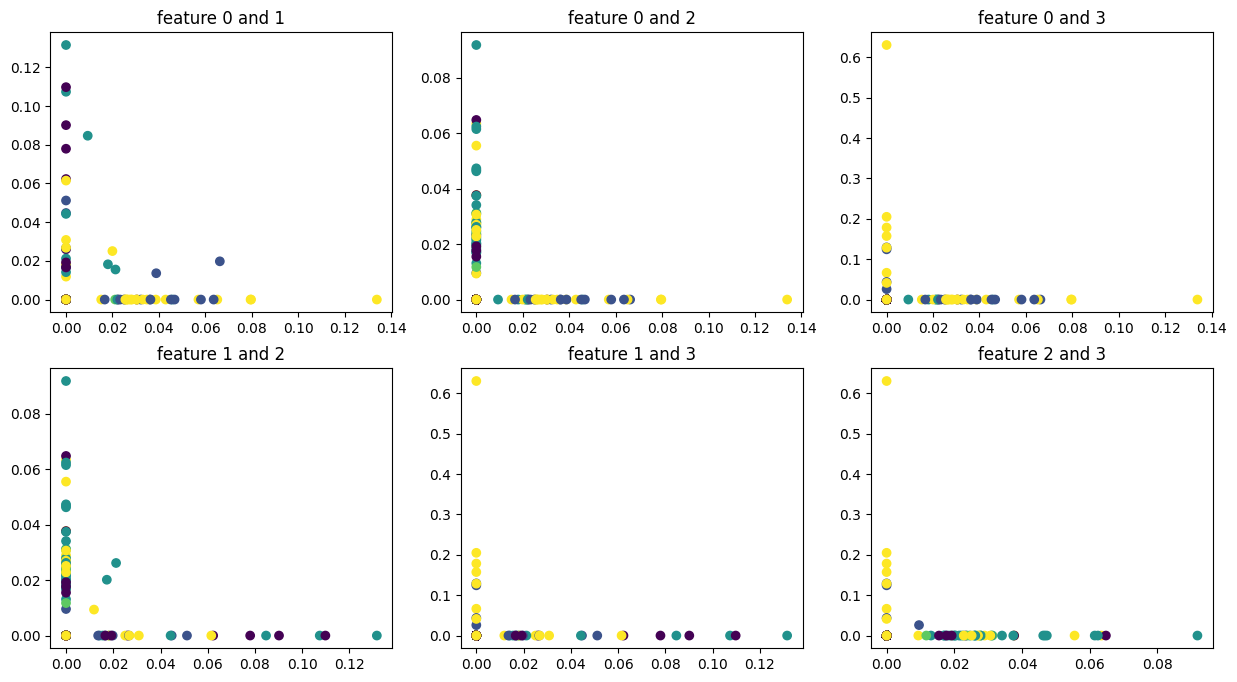

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15, 8))
c = 0
for i, j in [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]:
  c += 1
  plt.subplot(2, 3, c)
  plt.scatter(ratings_normalized[i], ratings_normalized[j], c = clusters)
  plt.title('feature {} and {}'.format(i, j))

plt.show()

**Ответ:** Визуализации получились такими, потому что они рассматривают только двух пользователей, и редко бывает, что у двух рандомных пользователей много общих исполнителей, которых они слушают, поэтому очень мало точек лежит над прямыми x=0 и y=0. Если точки лежат на прямой x=0 или y=0 и выше точки (0;0), значит этих исполнителей слушает только один из пользователей, если точки лежат в точке (0;0), значит этих исполнителей не слушает ни один из пользователей.

Данные визуализации плохо отражают разделение на кластеры, так как в многомерном пространстве кластеры могут быть хорошо разделимы, так как для разделения используется множество признаков, некоторый из которых могут быть очень важными, но в пдвумерном пространстве точки разных кластеров могут лежать на одной прямой и быть неразделимыми, особенно если эти два признака не вносят важный информативный вклад в разделение на кластеры (можно представить трехмерное пространство, в котором лежит кубик, а на определенном расстоянии ровно над ним находится еще один кубик, тогда получается, что в трехмерном пространстве они идеально разделимы, но, если посмотреть их проекцию на нижнюю ось, то они будут полностью совпадать).

Для визуализации данных высокой размерности существует метод t-SNE (стохастическое вложение соседей с t-распределением). Данный метод является нелинейным методом снижения размерности: каждый объект высокой размерности будет моделироваться объектов более низкой (например, 2) размерности таким образом, чтобы похожие объекты моделировались близкими, непохожие - далекими с большой вероятностью.

Примените `TSNE` из библиотеки `sklearn` и визуализируйте полученные объекты, покрасив их в цвета их кластеров

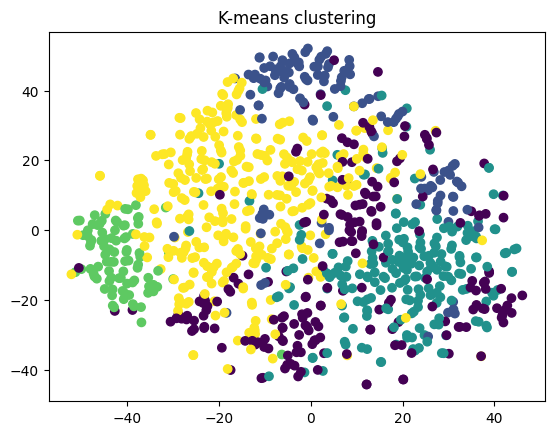

In [22]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, random_state = 0)
tsne_data = tsne.fit_transform(ratings_normalized)

tsne_df = pd.DataFrame(tsne_data, columns=['X', 'Y'])

plt.scatter(tsne_df['X'], tsne_df['Y'], c = clusters)
plt.title('K-means clustering')
plt.show()

В некоторых источниках пишут, что можно еще добавлять столбец с номерами кластеров к данным, чтобы при визуализации с помощью t-SNE кластеры были разделимы. На всякий случай сделал так:

In [42]:
# добавляем столбец с номерами кластеров к данным
ratings_normalized2 = ratings_normalized.copy()
ratings_normalized2[5000] = clusters

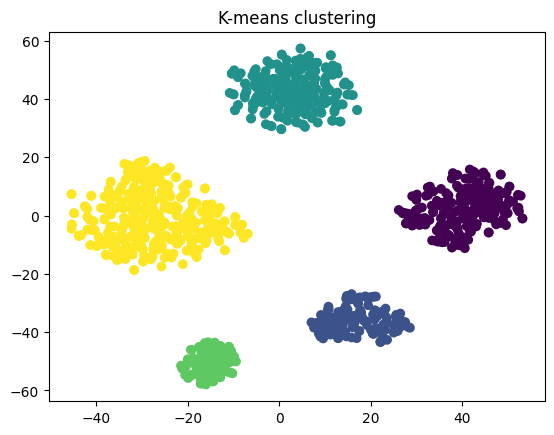

In [44]:
tsne_data = tsne.fit_transform(ratings_normalized2)

tsne_df = pd.DataFrame(tsne_data, columns=['X', 'Y'])

plt.scatter(tsne_df['X'], tsne_df['Y'], c = clusters)
plt.title('K-means clustering')
plt.show()

## Задание 7 (1 балл) Подбор гиперпараметров

Подберите оптимальное количество кластеров (максимум 100 кластеров) с использованием индекса Силуэта. Зафиксируйте `random_state=42`

In [ ]:
from sklearn.metrics import silhouette_score

best_k, best_score = None, -1
# для каждого количества кластеров обучаем и применяем KMeans, сохраняя наибольший индекс Силуэтов и количество кластеров, при котором он достигается
for k in range(2, 101):
    k_means = KMeans(n_clusters = k, random_state = 42)
    k_means = k_means.fit(ratings_normalized)
    clusters = k_means.predict(ratings_normalized)
    score = np.round(silhouette_score(X = ratings_normalized,
                             labels = clusters), 2)
    if score > best_score:
      best_score = score
      best_k = k
print('Best score {}, k = {}'.format(best_score, best_k))

Best score 0.02, k = 95


Выведите исполнителей, ближайших с центроидам (аналогично заданию 5). Как соотносятся результаты? Остался ли смысл кластеров прежним? Расскажите про смысл 1-2 интересных кластеров, если он изменился и кластеров слишком много, чтобы рассказать про все.

In [48]:
k_means = KMeans(n_clusters = best_k, random_state = 42)
k_means = k_means.fit(ratings_normalized)
clusters = k_means.predict(ratings_normalized)

In [49]:
from scipy.spatial.distance import cosine

centroids = k_means.cluster_centers_
top_10 = pd.DataFrame()

# для каждого центроида сортируем объекты по возрастанию расстояния по косинусной мере
for i in range(len(centroids)):
  distances = [cosine(centroids[i], ratings_normalized.iloc[j].values) for j in range(len(ratings_normalized))]
  artists_and_distances = pd.DataFrame({'distances' : distances}, index = ratings.index)
  top_10[i] = artists_and_distances.sort_values(by = 'distances', ascending = True)[0:10].index

top_10

,0,1,2,3,4,5,6,7,8,9,...,85,86,87,88,89,90,91,92,93,94
0,circa survive,the brian jonestown massacre,squarepusher.,talib kweli,mgmt,my bloody valentine,destinys child,the all-americian rejects,u2,the lawrence arms,...,evril lavigne,shiny toy guns,eminem,gillian welch,akira yamaoka,lamb,ray charles,underoath,sly & the family stone,boston
1,portugal. the man,spiritualized®,autechre,the roots featuring d'angelo,vampire weekend,deerhunter,janet jackson.,plain white t＇s,r.e.m.,jawbreaker,...,rent: original broadway cast,she wants revenge,50 cent,townes van zandt,kaki king,nightmares on wax?,the band,norma jean,curtis mayfield,foreigner-
2,cursive,black rebel motorcycle club,amon tobin,mos def,tokyo police club,animal collective,rihanna & jay-z,the red jumpsuit apparatus,coldplay,dillinger four,...,michelle branch,cascada,big l,neko case,the offspring,tйlйpopmusik,stevens. cat,emery,prince,styx
3,citya and colour,the dandy warhols,boards of canada,little brother,ratatat,slowdive,mariah carey,hellogoodbye,bruce springsteen,the glaslight anthem,...,the goo goo dools,basshunter,tupak shakur,old crow medicine show,yes,tosca,"reinhardt, django",saosin,james brown,the cars
4,the blood brothers,the verve,aphex twin,common,kings of leon,beach house,mary j. blige,secondhand serenade,bon jovi,alkaline trio,...,nelly furtado,brritney spears,dr. dre,josh ritter,bt,the cinematic orchestra,cocteau twins,a day to remember,snoop doggy dogg featuring jd,eltron john
5,coheed and cambria,silver jews,prefuse 73,jurassic 5,the klaxons,asobi seksu,the pussycat dolls,the fray,oasis,hot water music,...,tatu,timbaland,immortal technique,npr,she & him,morcheeba,louıs armstrong,silverstein,the cramps,the eagles
6,four year strong,pavement,underworld,cunninlynguists,justice,liars,beyoncé,mae,oingo boingo,descendents,...,good charlotte,beyoncé,m.i.a.,alison krauss & union station,greenday,tricky & dj muggs & grease,Ｂille holiday,alexisonfire,matvin gaye,journey
7,owen,the jesus and mary chain,rjd2,lupe the gorilla,los campesinos!,broadcast,aaliyah,blue october,indigo girlz,lifetime,...,pink,digitalism,bone: thugs~n~harmony,jethro tull,beck*,röyksopp,dylan. bob,fear before the march of flames,the temptations,billy joel
8,why?,velvet underground,burial,nas,the dodos,pavement,alicia keys,bowling for soup,jon brion,propagandhi,...,veronicas,the bravery,chamillionaire,ani difranco,metallica,sia,the beatles,hawthorne heights,al green,jack’s mannequin
9,manchester orchestra,sonic youth,björk guğmunsdóttir,a tribe called quest,au rivoir simone,the jesus and mary chain,fergie,lostprophets,pearl jam,lucero,...,backstreet boys,evril lavigne,the game,"young, neil",red hot clili peppers,imogen_heap,hank williams,thursday,thelonious monk,electric light orchestra


**Ответ:** Аналогично заданию 5 мы получили для каждого кластера топ-10 самых похожих между собой исполнителей, так как они лежат ближе всего к центроиду, но, так как кластеров теперь 95, а не 5, то каждый из них имеет более глубокий смысл, так как к каждому кластеру относится не так много наблюдений, то есть свойства, которыми эти наблюдения обладают, довольно уникальны, иначе к кластеру было бы отнесено намного больше наблюдений.

Кластеры все также содержат в себе исполнителей одних или похожих жанров, но теперь, так как кластеров больше, множество из них отражает поджанры. Более глубокий смысл двух кластеров опишем ниже:

In [50]:
top_10[59]

0       Бах Иоганн Себастьян
1                   ВИВАЛЬДИ
2    Вольфганг Амадей Моцарт
3                      ШОПЕН
4         ルートヴィヒ・ヴァン・ベートーヴェン
5                 Йrik satie
6              philip glassp
7                       enya
8          john williams (g)
9               miles davis.
Name: 59, dtype: object

**Ответ:** Все топ-10 самых похожих между собой представителей данного кластера - выдающиеся композиторы, они представляют разные эпохи: романтизма, барокко, классицизма и так далее. Большинство из данные композиторов известны всему миру за их вклад в музыкальную индустрию, первых пять я даже проходил на уроках музыки. Данный кластер отличается от других тем, что рядом с центроидом находятся исполнители, большинство из которых являются представителями не современности, а XVII-XIX веков, остальные - XX века.

In [51]:
top_10[21]

0                     john lenon
1    george harrison and friends
2                 paul mcmartney
3                    the beatles
4            simon and garfunkel
5                       lou reed
6                        dr. dog
7                   matt pond pa
8                 the beach boys
9                     dylan. bob
Name: 21, dtype: object

**Ответ:** Из интересного в данном кластере то, что первые три исполнителя: John Lennon, George Harrison, Paul McCartney известны как участники легендарной группы The Beatles, которая также включена в этот топ и находится на одну позицию ниже ее представителей. Исходя из этого, можно сделать вывод, что KMeans хорошо разделил наши данные на кластеры, так как, например, для одного из центроидов три ближайших исполнителя из одной музыкальной группы, как и должно быть, так как музыка этих исполнителей между собой максимально похожа.

Сделайте t-SNE визуализацию полученной кластеризации.

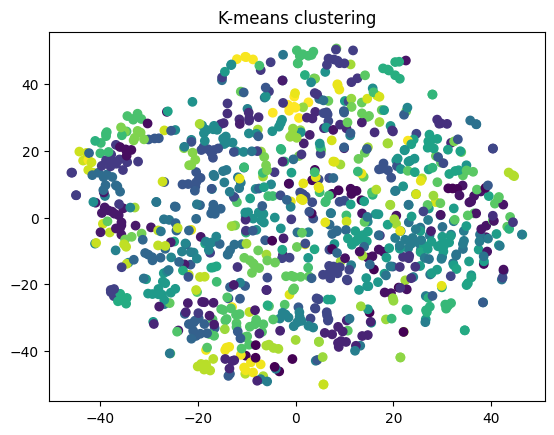

In [52]:
tsne = TSNE(n_components = 2, random_state = 42)
tsne_data = tsne.fit_transform(ratings_normalized)

tsne_df = pd.DataFrame(tsne_data, columns=['X', 'Y'])

plt.scatter(tsne_df['X'], tsne_df['Y'], c = clusters)
plt.title('K-means clustering')
plt.show()

Если кластеров получилось слишком много и визуально цвета плохо отличаются, покрасьте только какой-нибудь интересный кластер из задания выше (`c = (labels == i)`). Хорошо ли этот кластер отражается в визуализации?

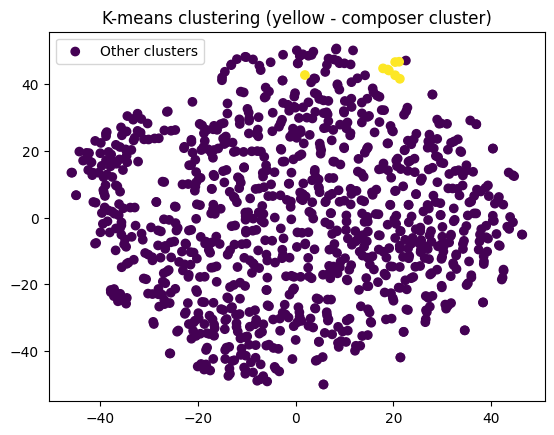

In [ ]:
tsne_data = tsne.fit_transform(ratings_normalized)

tsne_df = pd.DataFrame(tsne_data, columns=['X', 'Y'])

plt.scatter(tsne_df['X'], tsne_df['Y'], c = (clusters == 59), label = 'Other clusters')
plt.title('K-means clustering (yellow - composer cluster)')
plt.legend()
plt.show()

**Ответ:** По графику видно, что все объекты, кроме одного, находятся очень близко друг к другу (если покрасить другие кластеры, то большинство из них будет находиться не так кучно, как в данном случае), так что данный кластер хорошо отражается в визуализации, ведь объекты одного кластера должны располагаться кучно, так как похожи между собой.